# Multiple Sclerosis (MS) lesion segmentation of MRI images using a cascade of two 3D convolutional neural networks 


This script assumes that `Lasagne` and `nolearn` have been installed correctly and `CUDA / CUDNN` are configured. 

Import libraries: 

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import os
from collections import OrderedDict
from base import *
from build_model_tf import cascade_model
from config import *
import base
import numpy as np
import tracemalloc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model configuration:
Configure the model options. Options are passed to the model using the dictionary `options`. The main options are:

In [12]:
options = {}

# --------------------------------------------------
# Experiment parameters
# --------------------------------------------------

# image modalities used (T1, FLAIR, PD, T2, ...) 
#options['modalities'] = ['T1', 'FLAIR','GADO','DP','T2']
options['modalities'] = ['FLAIR']

# Select an experiment name to store net weights and segmentation masks
options['experiment'] = 'test_CNN'

# In order to expose the classifier to more challeging samples, a threshold can be used to to select 
# candidate voxels for training. Note that images are internally normalized to 0 mean 1 standard deviation 
# before applying thresholding. So a value of t > 0.5 on FLAIR is reasonable in most cases to extract 
# all WM lesion candidates
options['min_th'] = 0.5

# randomize training features before fitting the model.  
options['randomize_train'] = True

# Select between pixel-wise or fully-convolutional training models. Although implemented, fully-convolutional
# models have been not tested with this cascaded model 
options['fully_convolutional'] = False


# --------------------------------------------------
# model parameters
# --------------------------------------------------

# 3D patch size. So, far only implemented for 3D CNN models. 
options['patch_size'] = (11,11,11)

# percentage of the training vector that is going to be used to validate the model during training
options['train_split'] = 0.25

# maximum number of epochs used to train the model
options['max_epochs'] = 1

# maximum number of epochs without improving validation before stopping training (early stopping) 
options['patience'] = 1

# Number of samples used to test at once. This parameter should be around 50000 for machines
# with less than 32GB of RAM
options['batch_size'] = 32

# net print verbosity. Set to zero for this particular notebook, but setting this value to 11 is recommended
options['net_verbose'] = 1

# post-processing binary threshold. After segmentation, probabilistic masks are binarized using a defined threshold.
options['t_bin'] = 0.8

# The resulting binary mask is filtered by removing lesion regions with lesion size before a defined value
options['l_min'] = 20


## Experiment configuration:

Organize the experiment. Although not necessary, intermediate results, network weights and final lesion segmentation masks are stored inside a folder with name `options['experiment']`. This is extremely useful when a lot of experiments are computed on the same images to declutter the user space. 

In [42]:
exp_folder = os.path.join(os.getcwd(), options['experiment'])
if not os.path.exists(exp_folder):
    os.mkdir(exp_folder)
    os.mkdir(os.path.join(exp_folder,'nets'))
    os.mkdir(os.path.join(exp_folder,'.train'))

# set the output name 
options['test_name'] = 'cnn_' + options['experiment'] + '.nii.gz'
fh = open("train_logging/train_stats_full_system.txt","w+")
fh.write("something")
fh.close()

## Load the training data:

Training data is internally loaded by the method. So far, training and testing images are passed as dictionaries, where each training image is stored as follows: 

```
traininig_X_data['image_identifier'] = {'modality_1': /path/to/image_modality_n.nii.gz/,
                                         ....
                                        'modality_n': /path/to/image_modality_n.nii.gz/}
```

And also for labels: 

```
traininig_y_data['image_identifier_1'] = 'path/to/image_labels.nii.gz/'
```

**NOTE**: As stated in the paper, input images have been already skull-stripped and bias corrected (N3, etc...) by the user before running the classifer.

In [16]:
train_folder = '../data/miccai2016/Preprocessed_training_dataset/'
train_mask_folder = '../data/miccai2016/Unprocessed_training_dataset/TrainingDataset_MSSEG/'
train_x_data = {}
train_y_data = {}

# TRAIN X DATA
for i in range (1):
    subj_name = 's' + str(i+1)
    train_x_data[subj_name] = {'FLAIR': train_folder + subj_name + '/FLAIR_preprocessed_downsampled.nii.gz' 
#                         'DP': train_folder + subj_name + '/DP_preprocessed.nii.gz',
#                         'GADO': train_folder + subj_name +  '/GADO_preprocessed.nii.gz', 
#                         'T1': train_folder + subj_name +  '/T1_preprocessed_downsampled.nii.gz',
#                        'T2': train_folder + subj_name +  '/T2_preprocessed_downsampled.nii.gz'}
                              }
    train_y_data[subj_name] = train_mask_folder + subj_name +  '/Consensus_downsampled.nii.gz'
    
train_x_data['s1']

{'FLAIR': '../data/miccai2016/Preprocessed_training_dataset/s1/FLAIR_preprocessed_downsampled.nii.gz'}

In [17]:
tracemalloc.start()

X,Y = load_training_data(train_x_data, train_y_data, options, model = None)

current, peak = tracemalloc.get_traced_memory()
print("Current memory usage is {0} MB; Peak was {1} MB".format(current / 10**6,peak / 10**6))
tracemalloc.stop()

Current memory usage is 545.120684 MB; Peak was 773.646078 MB


In [18]:
tracemalloc.get_tracemalloc_memory()

648

In [19]:
X.shape

(144580, 11, 11, 11, 1)

In [20]:
Y.shape

(144580,)

In [21]:
X_small = X[:1000,:,:,:]
Y_small = Y[:1000]
X_small.shape

(1000, 11, 11, 11, 1)

In [37]:
from tensorflow.keras import datasets, layers, models
channels = len(options['modalities'])
model1 = models.Sequential()
fh.write(model1.summary())

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [40]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])
fh.write("something")

9

In [22]:
options['weight_paths'] = os.getcwd()
model = cascade_model(options)
fh.write(model[0].summary())
fh.write(model[1].summary())

ValueError: Attempt to convert a value (1) with an unsupported type (<class 'numpy.int32'>) to a Tensor.

In [48]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=options['patience'], verbose=options['net_verbose'])
history1 = model[0].fit(X_small, Y_small, batch_size=128, epochs = options['max_epochs'], validation_split=options['train_split'], verbose=options['net_verbose'], callbacks = [earlystop_callback])

Train on 750 samples, validate on 250 samples
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 00072: early stopping

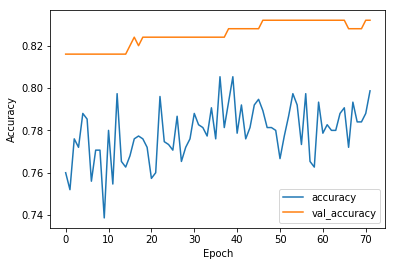

In [50]:
fig = plt.figure()
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
fig.savefig('../figures/model0_val_training_curve.jpg')

In [23]:
test_images = X[1000:2000,:,:,:]
test_labels = Y[1000:2000]
test_loss, test_acc = model[0].evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

1000/1 - 1s - loss: 0.2779 - accuracy: 0.8390
0.839


In [46]:
probability_model = tf.keras.Sequential([model[0], 
                                         tf.keras.layers.Softmax()])
probability_model.predict_proba(test_images)

array([[0.05878075, 0.9412192 ],
       [0.9955569 , 0.00444308],
       [0.9238999 , 0.07610016],
       ...,
       [0.24642698, 0.75357306],
       [0.9864406 , 0.01355936],
       [0.0516157 , 0.9483843 ]], dtype=float32)

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
sum(Y)

In [ ]:


fig = plt.figure(figsize=(7,5))

xy = X[0,0,6,:,:]

plt.imshow(xy, cmap='gray')



## Initialize the model:

The model is initialized using the function `cascade_model`, which returns a list of two `NeuralNet` objects. Optimized weights are stored also inside the experiment folder for future use (testing different images without re-training the model.  

In [ ]:
options['weight_paths'] = os.getcwd()
model = cascade_model(options)
model[0].summary()
model[1].summary()

## Train the model:

The function `train_cascaded_model` is used to train the model. The next image summarizes the training procedure. For further information about how this function optimizes the two CNN, please consult the original paper. (**NOTE**: For this example, `options['net_verbose`] has been set to `0` for simplicity)


![](pipeline_training.png)



In [ ]:
model, history1, history2 = train_cascaded_model(model, train_x_data, train_y_data,  options)


## Test the model:

Once the model has been trained, it can e tested on other images. Please note that the same image modalities have to be used. Testing images are loaded equally to training_data, so a `dictionary` defines the modalities used:

```
test_X_data['image_identifier'] = {'modality_1': /path/to/image_modality_n.nii.gz/,
                                         ....
                                   'modality_n': /path/to/image_modality_n.nii.gz/}
```


In [ ]:
# TEST X DATA
test_folder = '/mnt/DATA/w/CNN/images/test_images'
test_x_data = {}
test_x_data['im1'] = {'T1': os.path.join(test_folder,'im1', 'T1.nii.gz'), 
                       'FLAIR': os.path.join(test_folder,'im1', 'FLAIR.nii.gz')}


# set the output_location of the final segmentation. In this particular example, 
# we are training and testing on the same images
options['test_folder'] = test_folder
options['test_scan'] = 'im1'
out_seg = test_cascaded_model(model, test_x_data, options)


Compute different metrics on tested data:

In [ ]:
from metrics import *
# load the GT annotation for the tested image 
GT = nib.load(os.path.join(test_folder,'im1', 'lesion_bin.nii.gz')).get_data()
